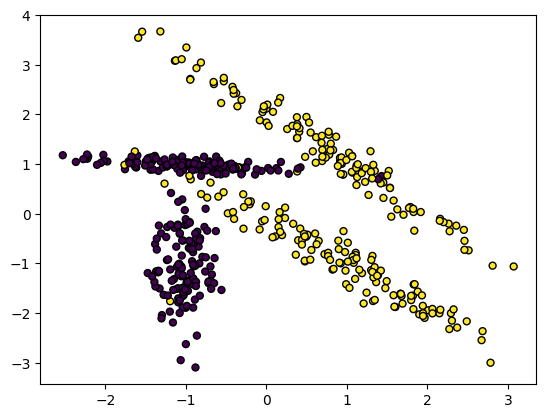

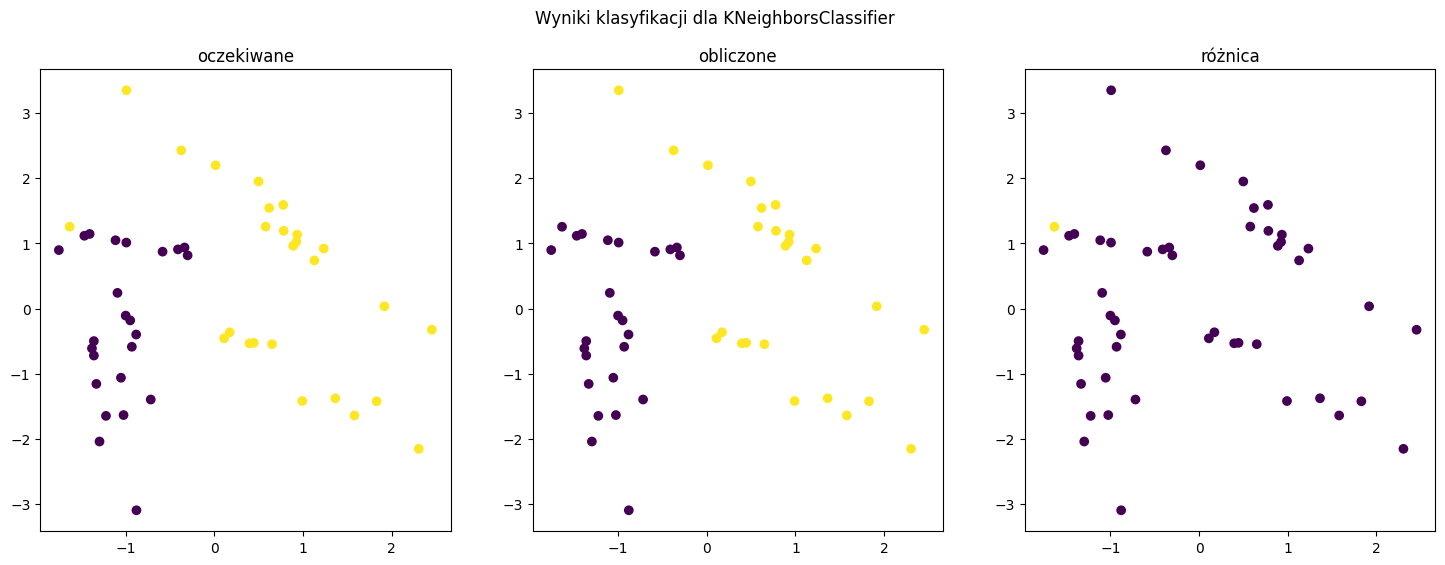

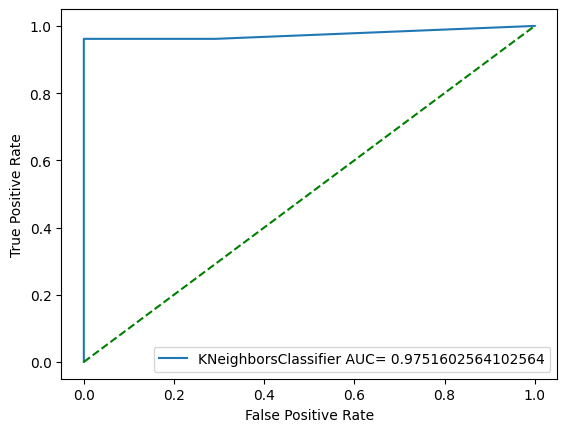

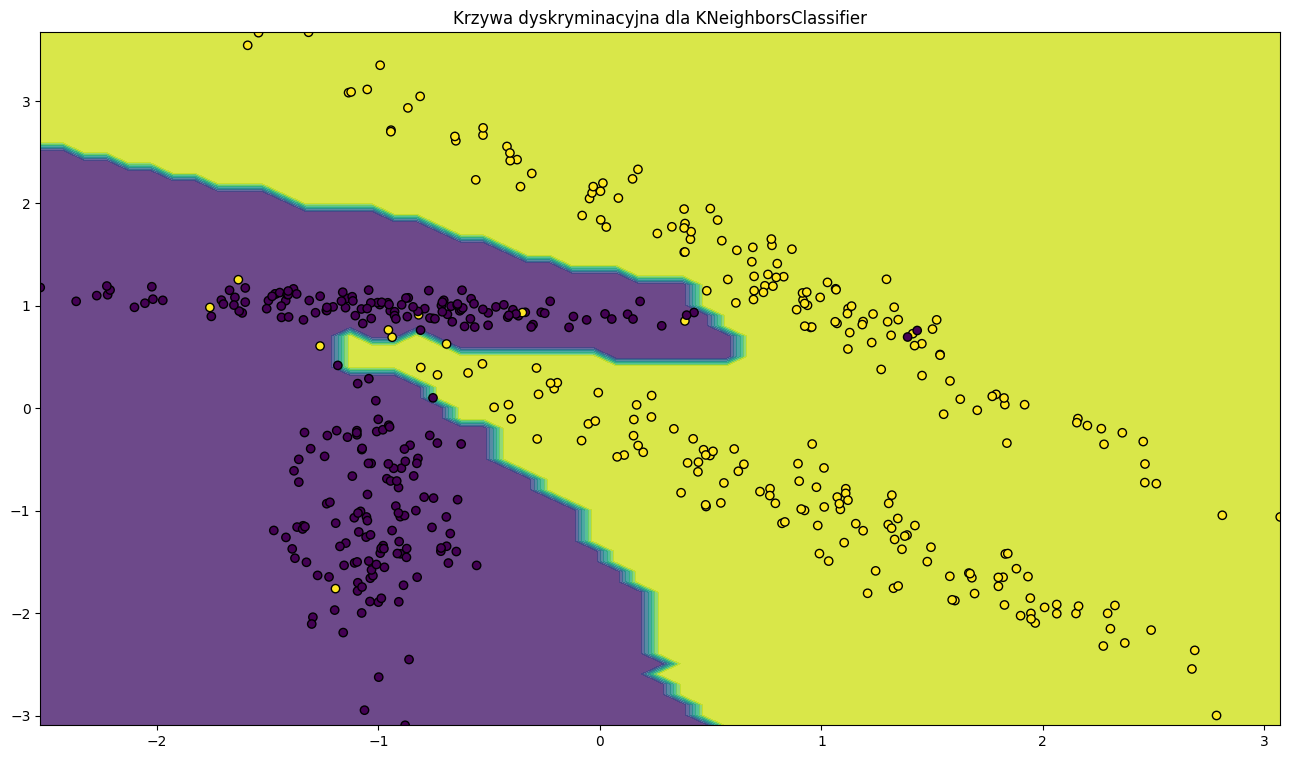

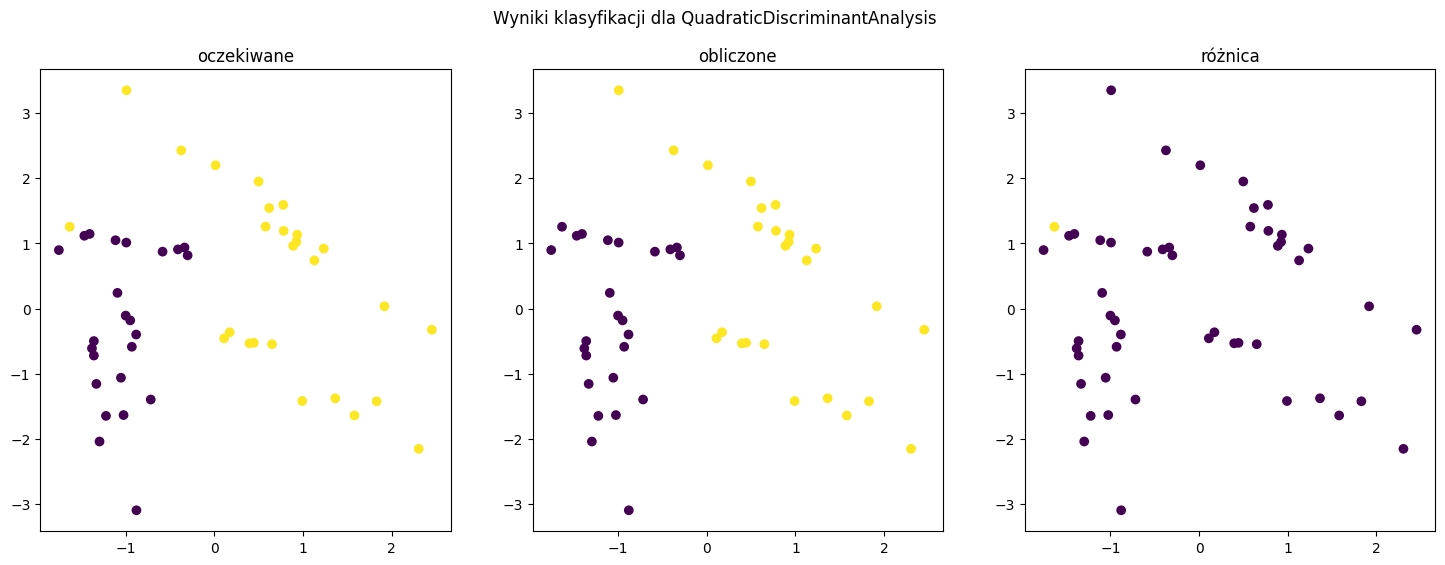

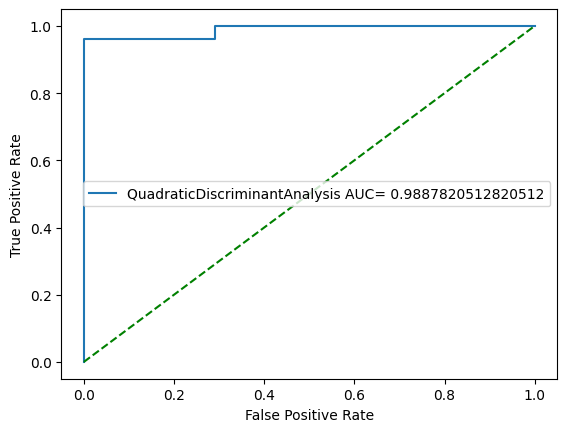

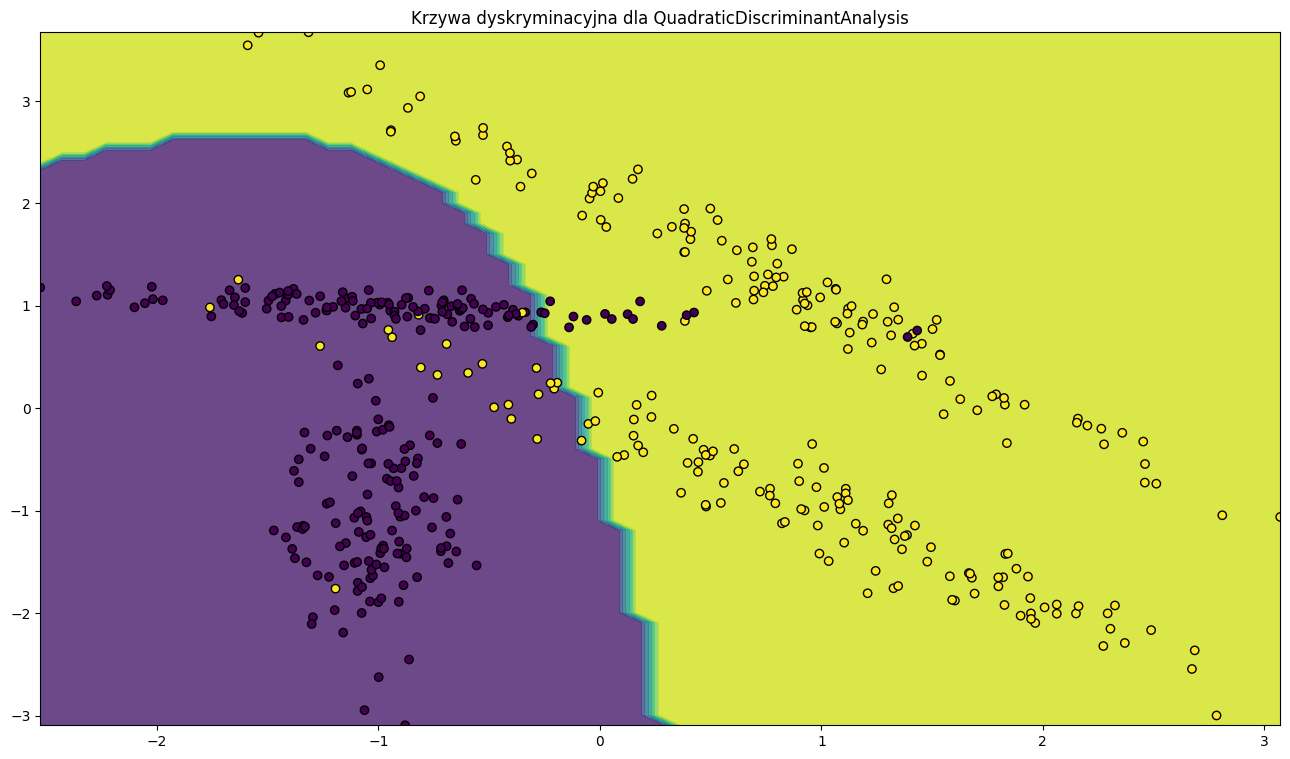

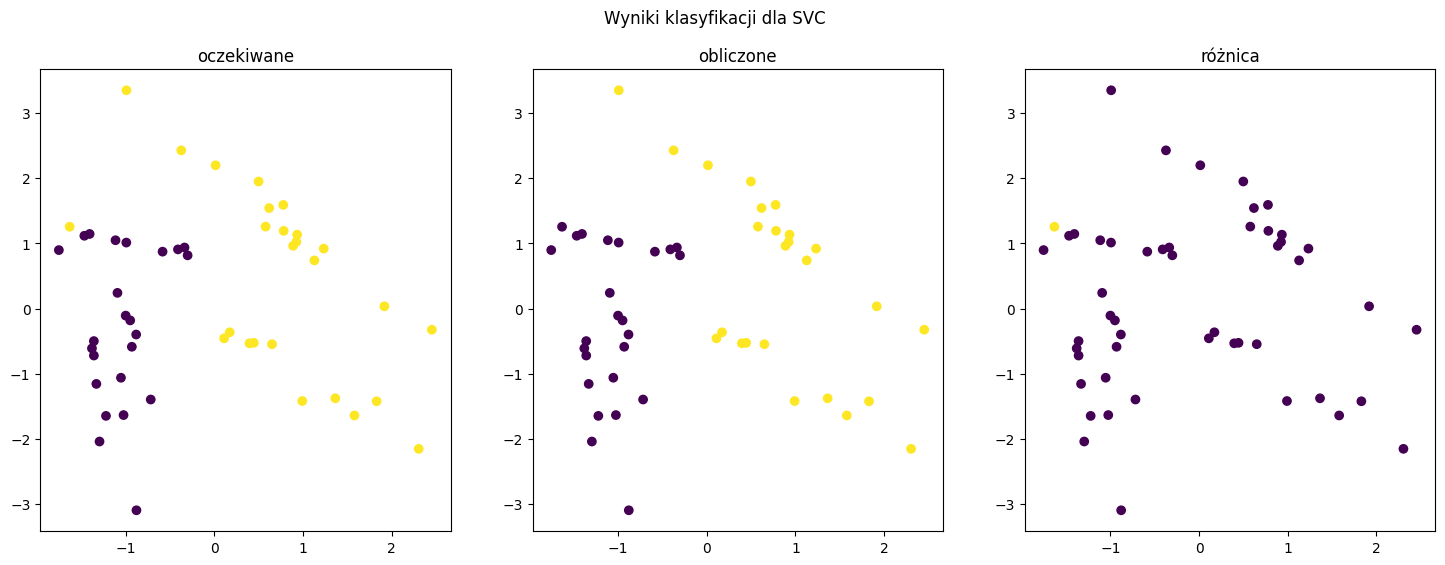

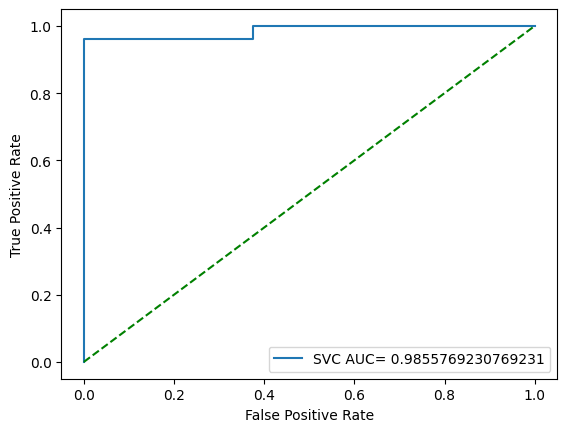

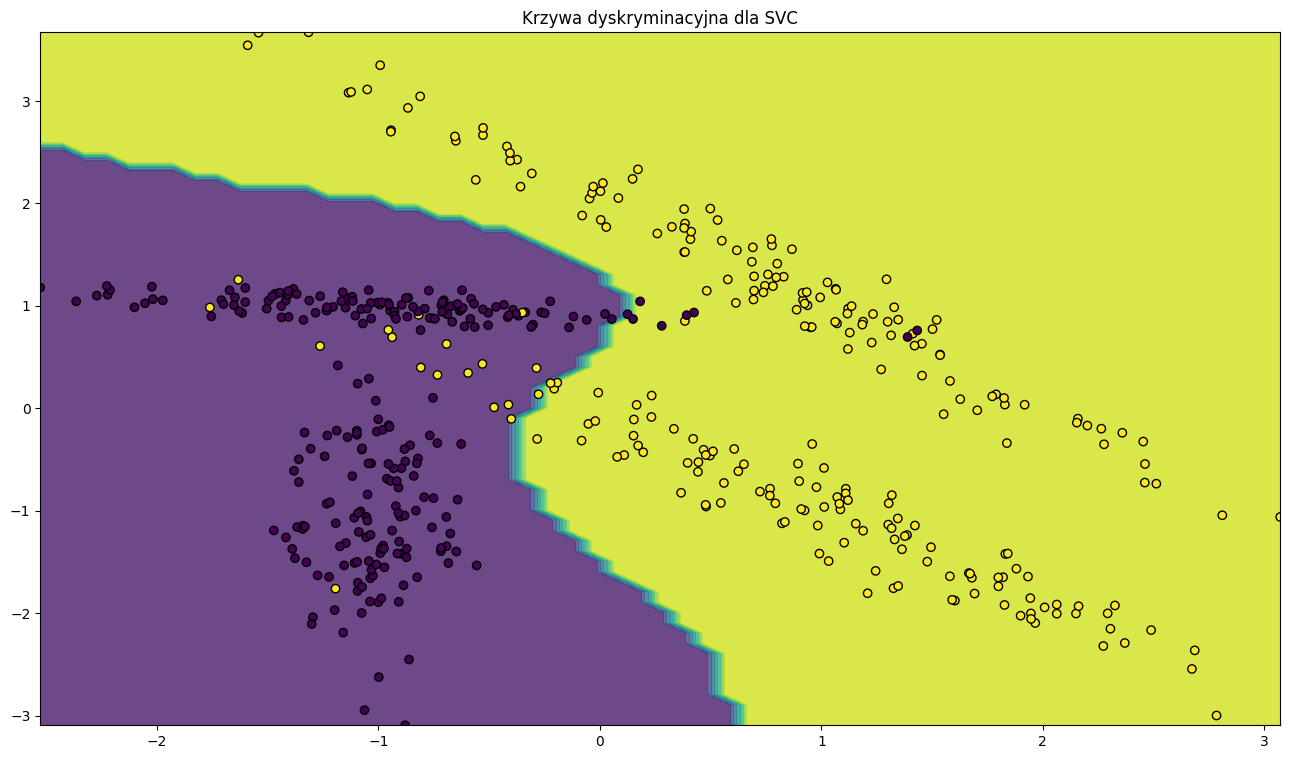

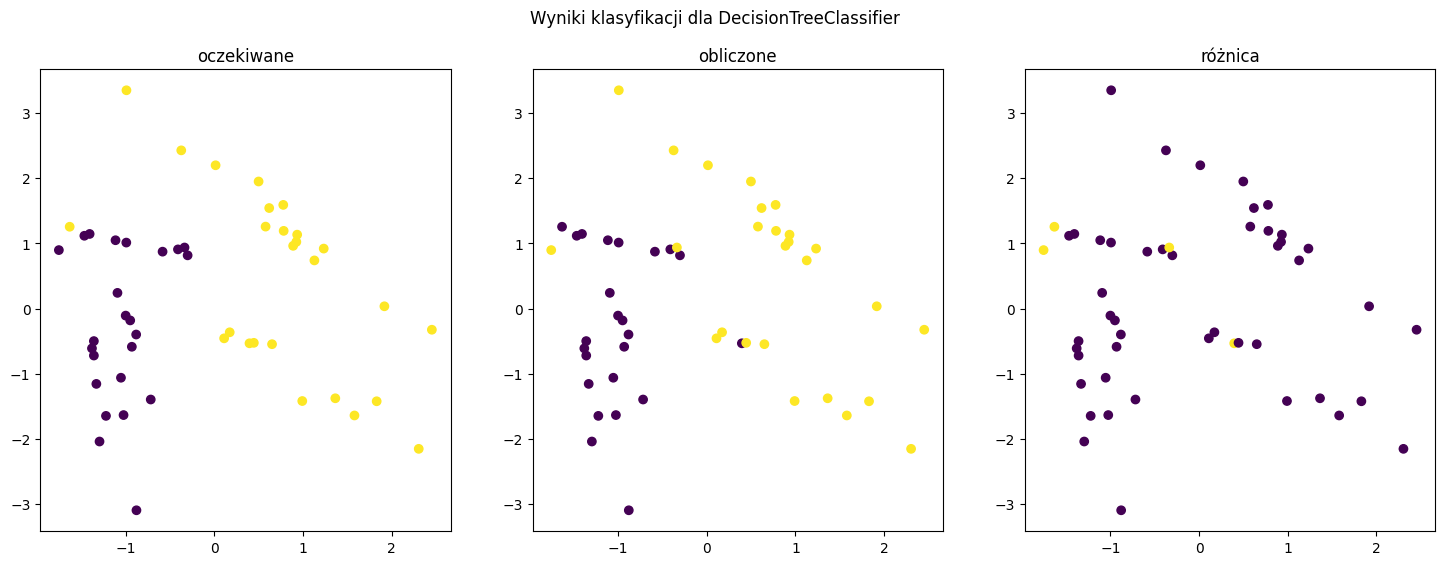

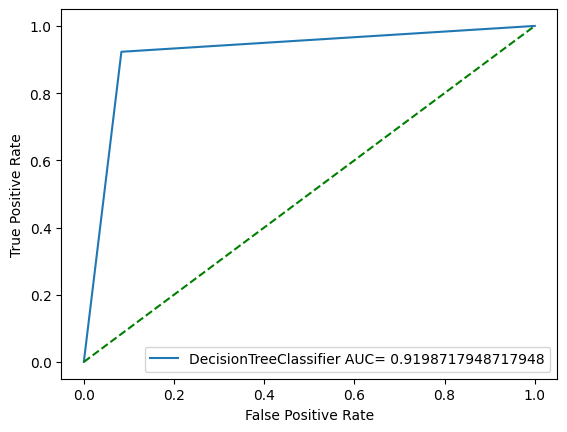

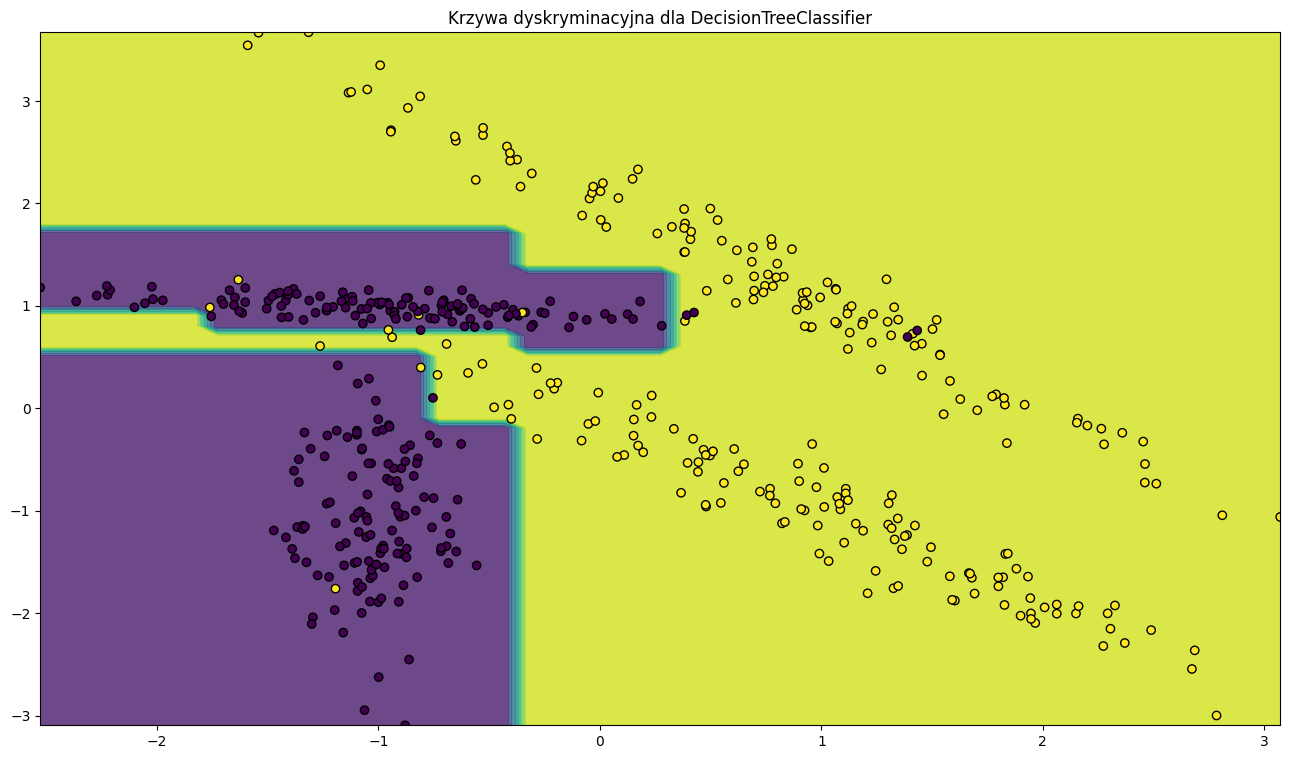

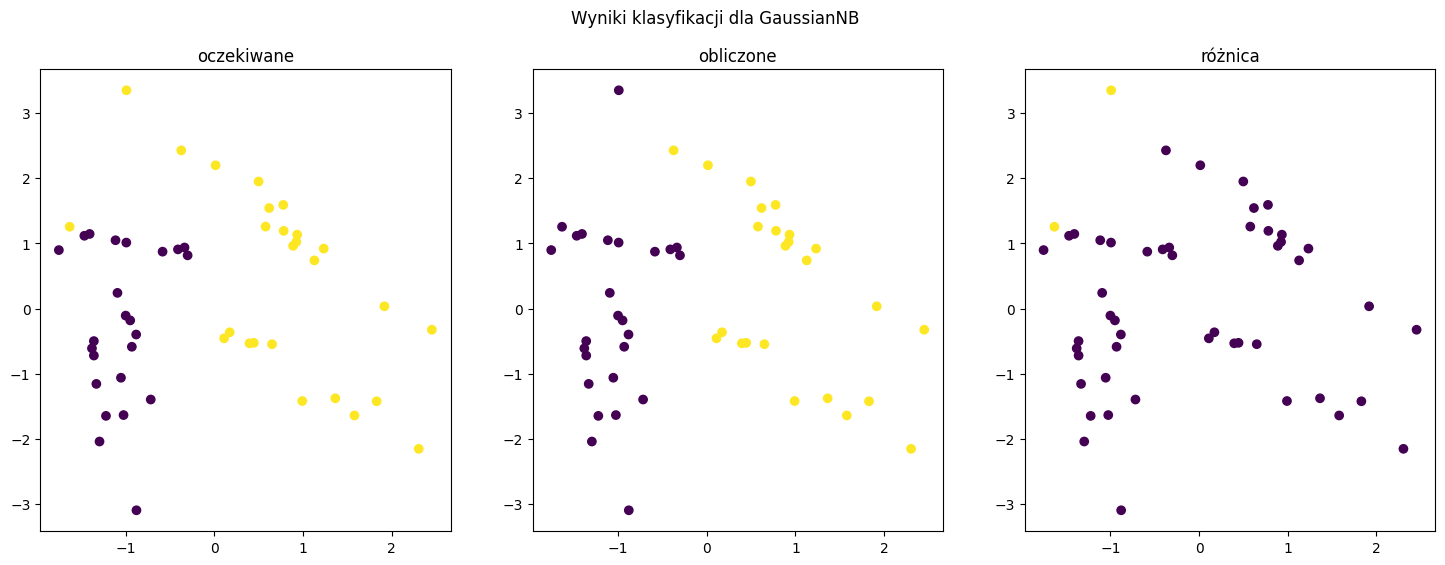

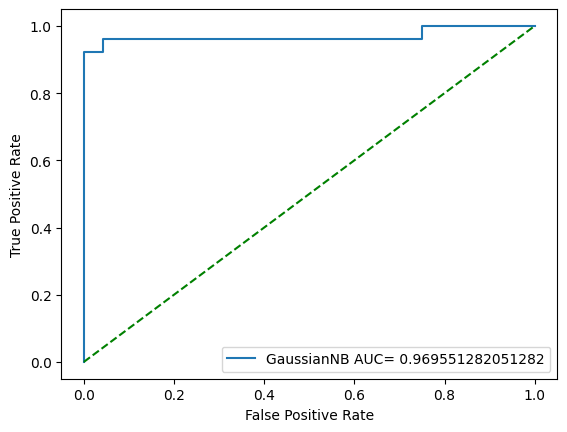

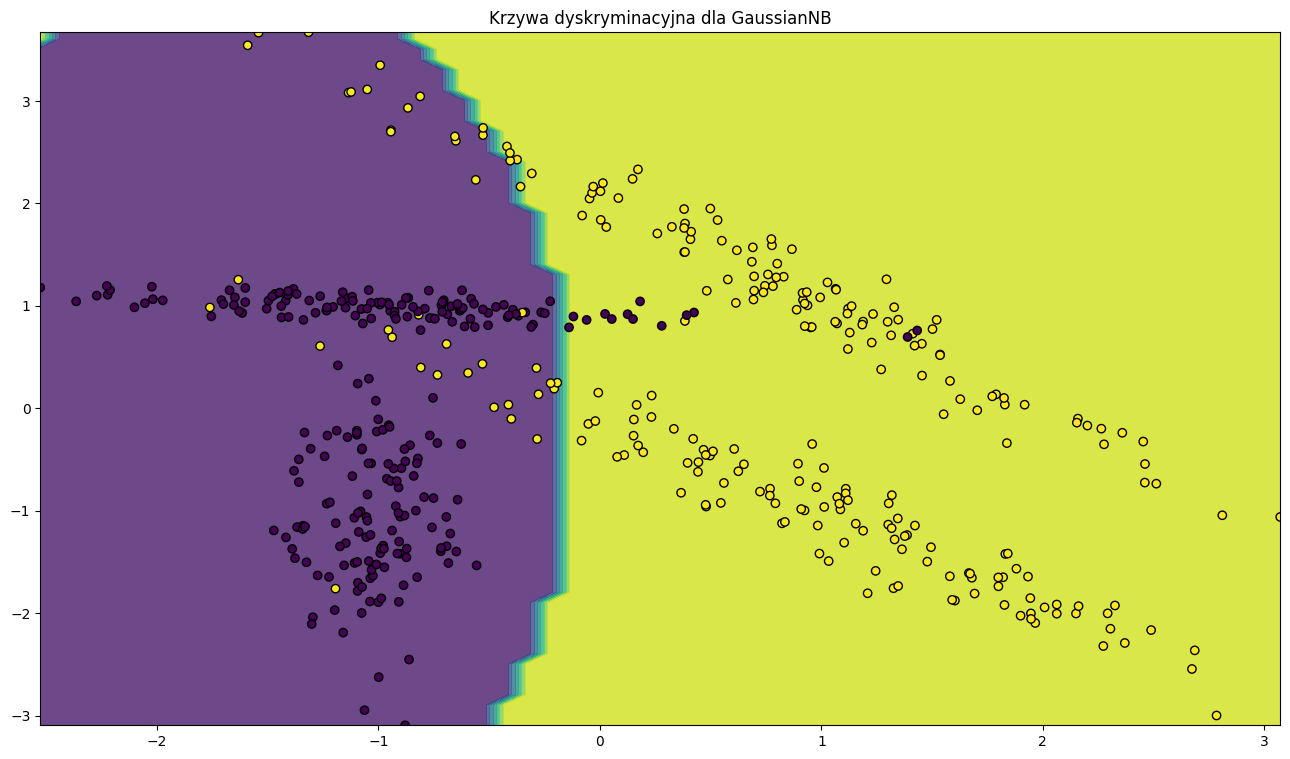

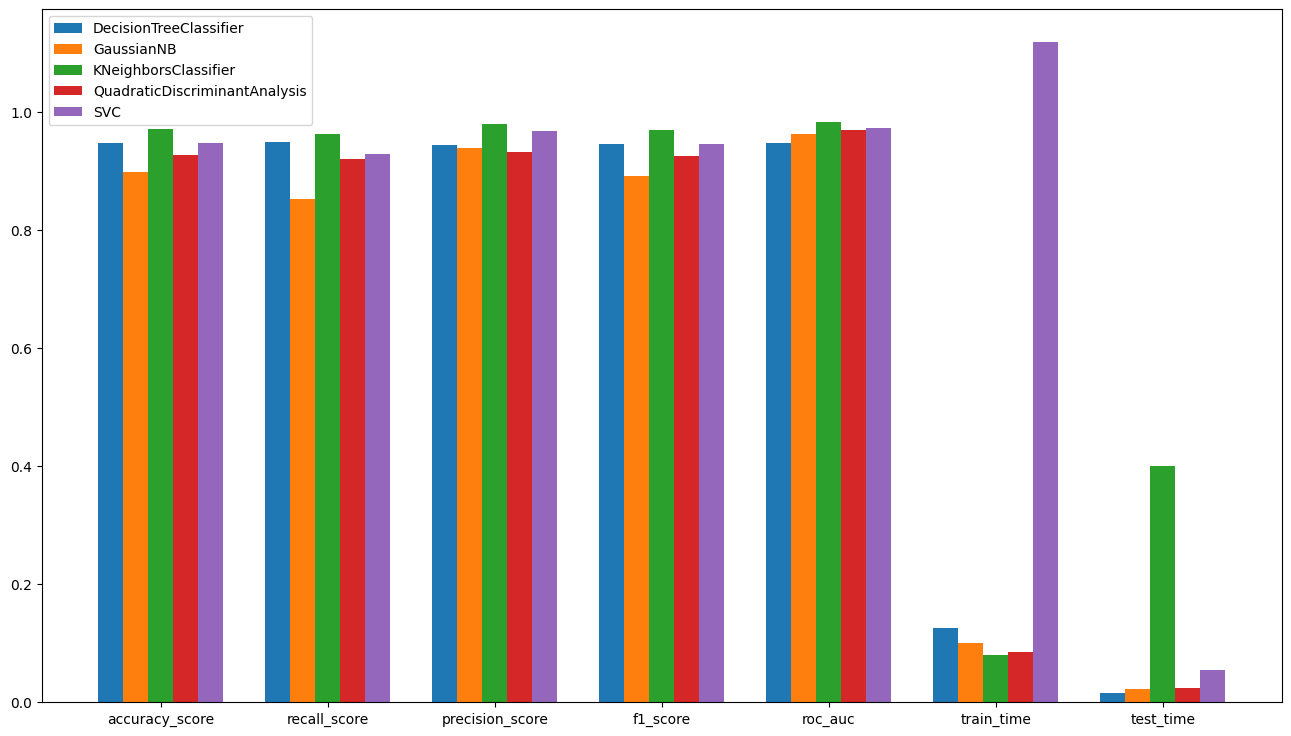

In [78]:
from sklearn import datasets
import timeit
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

X, y = datasets.make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_classes=2, n_clusters_per_class=2, random_state=3)
X.shape

plt.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolor="k")
plt.savefig("Scatter data")
classifiers = [
  KNeighborsClassifier(),
  QuadraticDiscriminantAnalysis(),
  SVC(probability=True),
  DecisionTreeClassifier(),
  GaussianNB(),
]

results = []

for i in range(100):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
  for clf in classifiers:
    start_train = timeit.default_timer()
    clf.fit(X_train, y_train)
    train_time = timeit.default_timer() - start_train

    start_test = timeit.default_timer()
    y_pred = clf.predict(X_test)
    test_time = timeit.default_timer() - start_test

    accuracy = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc = metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    results.append({
      'classifier': clf.__class__.__name__,
      'accuracy_score': accuracy,
      'recall_score': recall,
      'precision_score': precision,
      'f1_score': f1,
      'roc_auc': roc,
      'train_time': train_time,
      'test_time': test_time
    })
    if i == 99:
      #Poprawne/Niepoprawne klasyfikacje
      fig, axs = plt.subplots(1, 3, figsize=(18, 6))
      fig.suptitle(f'Wyniki klasyfikacji dla {clf.__class__.__name__}')

      axs[0].scatter(X_test[:, 0], X_test[:, 1], c = y_test)
      axs[0].set_title("oczekiwane")

      axs[1].scatter(X_test[:, 0], X_test[:, 1], c = y_pred)
      axs[1].set_title("obliczone")

      axs[2].scatter(X_test[:, 0], X_test[:, 1], c = (y_test != y_pred))
      axs[2].set_title("różnica")
      plt.savefig(f'Poprawność klasyfikacji dla {clf.__class__.__name__}')
      plt.show()

      #ROC
      #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions
      fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      plt.plot(fpr, tpr, label=clf.__class__.__name__ + ' AUC= ' + str(roc))
      plt.plot([0,1],[0,1], 'g--')
      plt.ylabel("True Positive Rate")
      plt.xlabel("False Positive Rate")
      plt.legend()
      plt.savefig(f'ROC dla {clf.__class__.__name__}')
      plt.show()

      #Granica decyzji
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

      #krok
      h = .1
      #meshgrid
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

      #Predykcja klasyfikatorem
      points = np.vstack((xx.ravel(), yy.ravel())).T
      Z = clf.predict(points)
      Z_reshaped = np.array(Z).reshape(xx.shape)

      #Rysowanie wykresu
      plt.figure(figsize=(16, 9))
      plt.contourf(xx, yy, Z_reshaped, alpha=0.8)
      plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
      plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
      plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
      plt.title(f'Krzywa dyskryminacyjna dla {clf.__class__.__name__}')
      plt.savefig(f'Krzywa dyskryminacyjna dla {clf.__class__.__name__}')
      plt.show()

results_df = pd.DataFrame(results)
grouped_results = results_df.groupby('classifier').mean().reset_index()
#print(grouped_results)

grouped_results['train_time'] = grouped_results['train_time'] * 100
grouped_results['test_time'] = grouped_results['test_time'] * 100

metrics = ['accuracy_score', 'recall_score', 'precision_score', 'f1_score', 'roc_auc', 'train_time', 'test_time']

num_metrics = len(metrics)
num_classifiers = len(grouped_results['classifier'])
bar_width = 0.15
indices = np.arange(num_metrics)

fig, ax = plt.subplots(figsize=(16, 9))

#https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
for i, classifier in enumerate(grouped_results['classifier']):
    metric_values = grouped_results.loc[grouped_results['classifier'] == classifier, metrics].values.flatten()
    ax.bar(indices + i * bar_width, metric_values, bar_width, label=classifier)

#to jest po to żeby nazwy grup słupków były widoczne
ax.set_xticks(indices + bar_width * (num_classifiers - 1) / 2)
ax.set_xticklabels(metrics)
ax.legend()
plt.savefig("Wykres słupkowy porównujący poszczególne klasyfikatory")
plt.show()

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 32, 'splitter': 'random'}
ROC AUC: 0.9898989898989898
Dokładność: 0.9


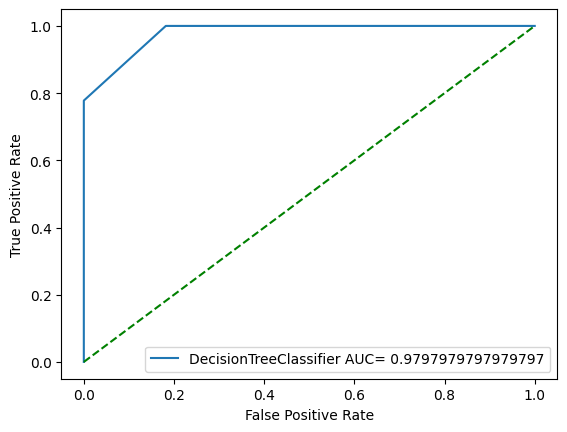

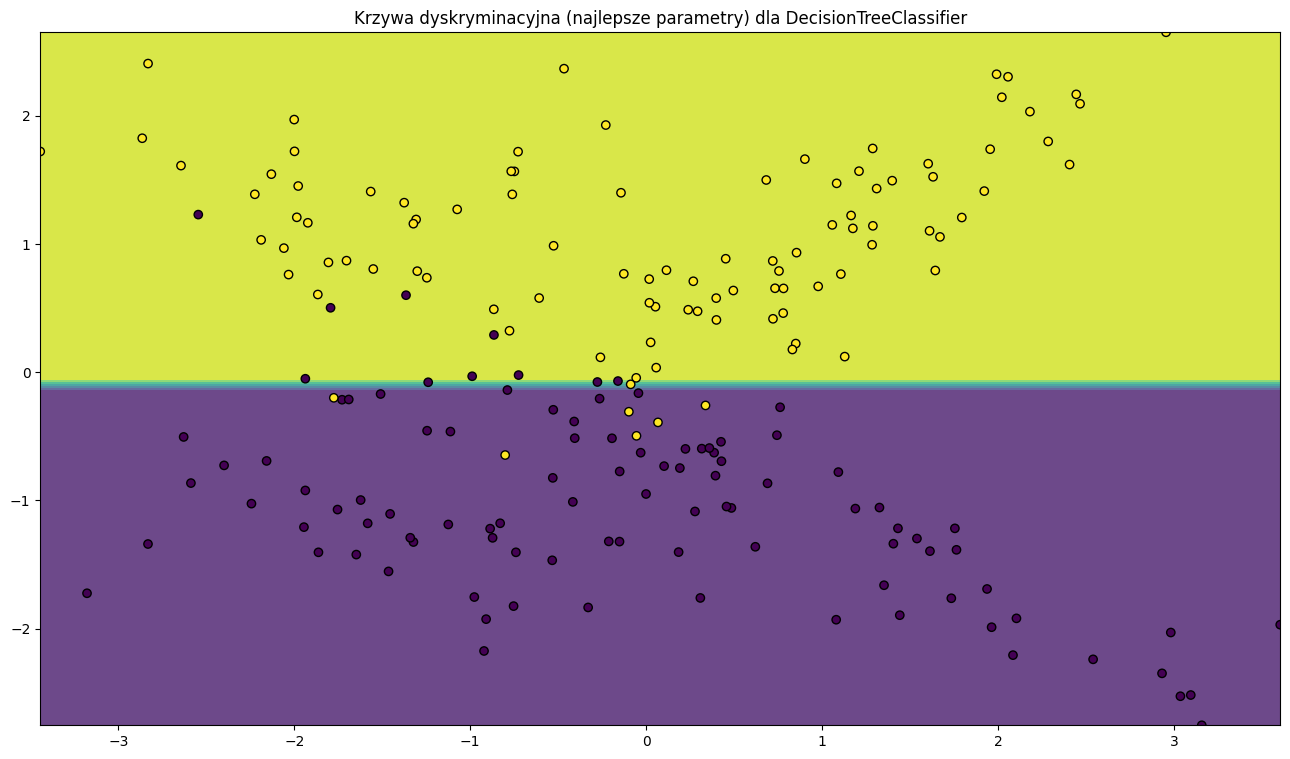

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, roc_curve, RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np


param_grid = {
    "DecisionTreeClassifier": {
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 4, 8, 16, 32],
        "min_samples_leaf": [1, 2, 4, 8, 16],
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"]
    }
}

# Generowanie danych przykładowych z dwoma cechami i dwiema klasami
X, y = datasets.make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2, n_classes=2, n_clusters_per_class=2, random_state=3)

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=3)

#GridSearch
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid["DecisionTreeClassifier"],
                           scoring='roc_auc', cv=5, verbose=1)

# Dopasowanie modelu
grid_search.fit(X_train, y_train)

# Najlepsze parametry
best_params = grid_search.best_params_
print("Najlepsze parametry:", best_params)

#Oceń na podstawie zbioru testowego
best_clf = grid_search.best_estimator_
#print(grid_search.cv_results_)
y_pred = best_clf.predict(X_test)
roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

print("ROC AUC:", roc_auc)
print("Dokładność:", accuracy)

##część na wykresy związane z dwoma najważniejszymi parametrami

##iteracje

results = []

for i in range(100):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=3)

  #czas dopasowania
  start_train = timeit.default_timer()
  best_clf.fit(X_train, y_train)
  train_time = timeit.default_timer() - start_train

  #czas klasyfikowania
  start_test = timeit.default_timer()
  y_pred = best_clf.predict(X_test)
  test_time = timeit.default_timer() - start_test

  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])

  results.append({
    'accuracy_score': accuracy,
    'recall_score': recall,
    'precision_score': precision,
    'f1_score': f1,
    'roc_auc': roc,
    'train_time': train_time,
    'test_time': test_time
  })
  if i == 99:
    #ROC
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions
    fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=best_clf.__class__.__name__ + ' AUC= ' + str(roc))
    plt.plot([0,1],[0,1], 'g--')
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend()
    plt.savefig(f'ROC (najlepsze parametry) dla {best_clf.__class__.__name__}')
    plt.show()

    #Granica decyzji
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    #krok
    h = .1
    #meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

      #Predykcja klasyfikatorem
    points = np.vstack((xx.ravel(), yy.ravel())).T
    Z = best_clf.predict(points)
    Z_reshaped = np.array(Z).reshape(xx.shape)

    #Rysowanie wykresu
    plt.figure(figsize=(16, 9))
    plt.contourf(xx, yy, Z_reshaped, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    plt.title(f'Krzywa dyskryminacyjna (najlepsze parametry) dla {best_clf.__class__.__name__}')
    plt.savefig(f'Krzywa dyskryminacyjna (najlepsze parametry) dla {best_clf.__class__.__name__}')
    plt.show()
